## Style Transfer

#### The [Gatys Paper](https://arxiv.org/abs/1508.06576) Style Transfer Network Used as Perceptual Loss

The Gatys Style Transfer

* From [this very paper](https://arxiv.org/abs/1508.06576)
* Though GAN is better for the task recently, but this style transfer is a good exercise

The perceptual loss

* From [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](http://arxiv.org/abs/1603.08155)

In [1]:
from torchvision.models.vgg import vgg16
import torch
from torch import nn
torch.cuda.empty_cache()

Replacing all the maxpool to avgpool, drop less info, much more visually pleasing

In [2]:
def get_avgpool_vgg():
    vgg_model = vgg16(pretrained=True)
    for layer_i in range(len(vgg_model.features)): 
        if type(vgg_model.features[layer_i])==torch.nn.modules.pooling.MaxPool2d:
            vgg_model.features[layer_i] = torch.nn.modules.AvgPool2d(kernel_size=2,stride=2,padding=0,ceil_mode=False)
    return vgg_model

vgg_model = get_avgpool_vgg()

In [3]:
CUDA = torch.cuda.is_available()

from forgebox.ftorch import FG
fg = FG("style_transfer_percept_loss")
p = fg.p

==========hyper params==========
{'height': 240, 'width': 320, 'seqlen_sty': 1000, 'epochs_sty': 1, 'ctt_wgt': 100000.0, 'tv_sty_wgt': 0.1}


#### Check The Model Structure

In [4]:
vgg_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU(inplace)
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

#### Establish Learnable Image

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [6]:
p("height",240)
p("width",320)

320

In [7]:
if CUDA:
    def param_2_npimg(img):
        img_np = img.cpu().data.numpy()
        return np.clip(np.squeeze(img_np,axis=0),0.,1.)
else:
    def param_2_npimg(img):
        img_np = img.data.numpy()
        return np.clip(np.squeeze(img_np,axis=0),0.,1.)

def show_img(img):
    return plt.imshow(param_2_npimg(img))

def save_img(img, path):
    return plt.imsave(path,param_2_npimg(img))

#### Iterator, Images, loss

In [8]:
from PIL import Image
from torch.optim import Adam
from torch.utils.data.dataset import Dataset
from forgebox.ftorch.train import Trainer
from pathlib import Path
import os

mse_func = nn.MSELoss()

In [9]:
def tv_func(y):
    """
    total variation loss function
    return the total variation of an image
    measures how much a pixel varies to its neighbour
    """
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:]))+torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

def torch_shape(img):
    """
    Swap the dimensions for python is bs,h,w,c, but the image we opened is bs,c,h,w
    """
    return img.permute(0,3,1,2)

In [10]:
HOME = Path(os.environ["HOME"])
DATA = HOME/"data"

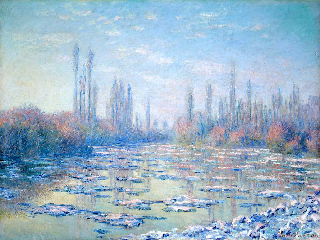

In [11]:
style_img = Image.open(DATA/"style_transfer"/"style"/"monet.jpg")
style_arr = torch_shape(torch.FloatTensor(np.expand_dims(np.array(style_img.resize((p("width"),p("height")))),axis=0))/255)

if CUDA: style_arr = style_arr.cuda()
style_img.resize((p("width"),p("height")))

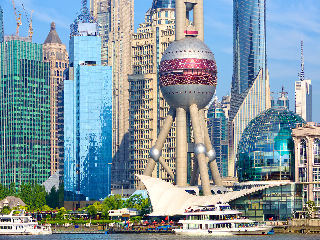

In [12]:
ctt_img = Image.open(DATA/"style_transfer"/"img"/"shanghai.jpg",)
ctt_img = ctt_img.convert('RGB')
ctt_arr = torch_shape(torch.FloatTensor(np.expand_dims(np.array(ctt_img.resize((p("width"),p("height")))),axis=0))/255)
if CUDA: ctt_arr = ctt_arr.cuda()
ctt_img.resize((p("width"),p("height")))

#### Dataset

In [13]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [14]:
trans = transforms.Compose([
                    transforms.Resize((p("height"),p("width"))),
                    transforms.ToTensor(),])
#                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                   

In [15]:
ds = ImageFolder("/data/coco/",transform = trans)

In [16]:
from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size= 4, shuffle = True, num_workers=8)
gen = iter(dl)

x, y = next(gen)
x.size()

torch.Size([4, 3, 240, 320])

In [17]:
# from tqdm import trange
# gen = iter(dl)
# for ba in trange(len(dl)):
#     next(gen)

#### Style Transfer

Content Reconstruction + Style Reconstruction

In [18]:
def conv(ni,nf, ks = 3, stride=1,actn=True, pad=None, bn=True):
    pad = ks//2 if pad == None else pad
    layers = [nn.Conv2d(ni, nf,ks, stride=stride, padding = pad, bias = not bn)]
    if actn: layers.append(nn.ReLU(inplace = True))
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

class ResSequentialCenter(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.m = nn.Sequential(*layers)
        
    def forward(self,x): return x[:,:,2:-2,2:-2]+self.m(x)
    
def res_block(nf):
    return ResSequentialCenter([conv(nf, nf,actn=True, pad=0),conv(nf, nf,pad=0)])

def upsample(ni, nf):
    return nn.Sequential(nn.Upsample(scale_factor=2,), conv(ni,nf))

class Convert(nn.Module):
    def __init__(self):
        super().__init__()
        features=[
            nn.ReflectionPad2d(40), # H+=80,W+=80
            conv(3,32,9),
            conv(32,64,stride=2), # H/=2, W/=2
            conv(64,128,stride=2), # H/=2, W/=2
                    ]
        features += list(res_block(128) for i in range(5)) 
        features += [
            upsample(128,64),
            upsample(64,32),
            conv(32,3,9,actn=False)
                    ]
        self.features = nn.Sequential(*features)
        if CUDA: self.cuda()
        
    def forward(self,x):
        return torch.sigmoid(self.features(x))
    

In [19]:
def gram(img):
    return img@img.permute(0,1,3,2)

def gram_loss(pred,targ):
    targsize = tuple(targ.size())
    bs,ch,h,w = targsize
    return mse_func(gram(pred),gram(targ))/(ch*h*w)*1e6

In [20]:
con_indices = [6,11,18,25] # for conv_2_1, conv_3_1, conv_4_1, conv_5_1
con_wgt = [0.025,0.275,5.,0.2]
style_arr = style_arr.repeat(4,1,1,1)

trainer = Trainer(ds,batch_size=2,shuffle=True, print_on=2, num_workers = 6)
vgg_feat = vgg_model.features
if CUDA:vgg_feat = vgg_feat.cuda()

def calc_ctt_loss(img,ctt_arr,block_idx):
    layer_idx = con_indices[block_idx-1]
    ctt_rep1 = vgg_feat[:layer_idx](img)
    ctt_rep2 = vgg_feat[:layer_idx](ctt_arr).detach()
    return mse_func(ctt_rep1, ctt_rep2)

@trainer.step_train
def action(*args,**kwargs):
    """
    A training step for noise to learn style
    """
    x,_ = args[0]
    bs = x.size()[0]
    if CUDA: x = x.cuda()
    opt.zero_grad()
    
    img = convert(x)
    # content
    ctt_loss =  calc_ctt_loss(img,x,0)*p("ctt_wgt",1e5) # content loss
    # style
    style_losses = []
    for l in range(len(con_indices)): # for conv_1_1, conv_2_1, conv_3_1, conv_4_1, conv_5_1
        rep1 = vgg_feat[:con_indices[l]](img)
        rep2 = vgg_feat[:con_indices[l]](style_arr[:bs,:,:,:]).detach()
        
        style_losses.append(gram_loss(rep1,rep2)*con_wgt[l])
    
    sty_loss = sum(style_losses)
    style_losses = []
    
#     sty_loss*=p("sty_wgt",1) # style loss
    tv_loss = tv_func(torch_shape(img))*p("tv_sty_wgt",1e-1) # total variation loss
    loss = ctt_loss+sty_loss+tv_loss
    
    loss.backward()
    opt.step()
    
    if kwargs["ite"]%50 == 49:
        save_img(img[:1,:,:,:].permute(0,2,3,1),str(DATA/"style_transfer"/"result"/("%s.jpg"%(kwargs["ite"]))))
        
    return {"loss":loss.item(),"ctt":ctt_loss.item(),"sty":sty_loss.item(),"tv":tv_loss.item()}

In [ ]:
convert = Convert()

In [ ]:
opt = Adam(convert.parameters(),)
trainer.train(p("epochs_sty",1))

HBox(children=(IntProgress(value=0, max=59144), HTML(value='')))

In [ ]:
# show_img(convert(ctt_arr).permute(0,2,3,1))